# UCI Heart Disease Prediction - Classification Project

## Project Overview
Multi-class classification to predict severity of heart disease (0-4) using clinical and demographic features from the UCI Heart Disease dataset.

## Dataset
- Location: `../dataset/heart_disease_uci.csv`
- Target: `num` column (values: 0-4, where 0 = no disease, 1-4 = increasing severity)
- Size: 920 samples with 13 features
- Source: UCI Machine Learning Repository

## 1. Setup and Imports
**Task:** Import all necessary libraries and set up project paths and directories

In [5]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                            confusion_matrix, classification_report, roc_auc_score, 
                            roc_curve, precision_recall_curve)

# Model persistence
import joblib

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

# Configuration
DATA_PATH = Path(r'..\..\dataset\heart_disease_uci.csv')
OUTPUT_DIR = Path('outputs')
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)
(OUTPUT_DIR / 'figures').mkdir(exist_ok=True, parents=True)
(OUTPUT_DIR / 'models').mkdir(exist_ok=True, parents=True)

print("Setup complete!")

Setup complete!


## 2. Load and Inspect Data
**Task:** Load the dataset and perform initial inspection to understand its structure

In [6]:
# Load dataset
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}")

# Read CSV - handle missing values represented as empty strings or '?'
df = pd.read_csv(DATA_PATH, na_values=['NA', 'na', 'N/A', 'n/a', '', '?'])
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print("\n" + "="*50)
print("First 5 rows:")
print("="*50)
df.head()

Dataset shape: (920, 16)

Columns: ['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']

First 5 rows:


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


## 3. Data Quality Assessment
**Task:** Check for missing values, data types, and basic statistics

In [7]:
# Data types and basic info
print("Dataset Info:")
print("="*50)
df.info()

print("\n" + "="*50)
print("Missing Values:")
print("="*50)
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
if len(missing_df) > 0:
    print(missing_df)
else:
    print("No missing values found!")

print("\n" + "="*50)
print("Basic Statistics:")
print("="*50)
df.describe()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB

Missing Values:
          Missing Count  Percentage
ca                  611   66.413043
thal                486   

,id,age,trestbps,chol,thalch,oldpeak,ca,num
count,920.000000,920.000000,861.000000,890.000000,865.000000,858.000000,309.000000,920.000000
mean,460.500000,53.510870,132.132404,199.130337,137.545665,0.878788,0.676375,0.995652
std,265.725422,9.424685,19.066070,110.780810,25.926276,1.091226,0.935653,1.142693
min,1.000000,28.000000,0.000000,0.000000,60.000000,-2.600000,0.000000,0.000000
25%,230.750000,47.000000,120.000000,175.000000,120.000000,0.000000,0.000000,0.000000
50%,460.500000,54.000000,130.000000,223.000000,140.000000,0.500000,0.000000,1.000000
75%,690.250000,60.000000,140.000000,268.000000,157.000000,1.500000,1.000000,2.000000
max,920.000000,77.000000,200.000000,603.000000,202.000000,6.200000,3.000000,4.000000


## 4. Target Variable Analysis
**Task:** Analyze the target variable distribution and convert to binary classification

Target variable distribution:
num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64

Unique values: [0, 1, 2, 3, 4]

Binary target distribution:
target
0    411
1    509
Name: count, dtype: int64

Class balance: target
1    0.553261
0    0.446739
Name: proportion, dtype: float64


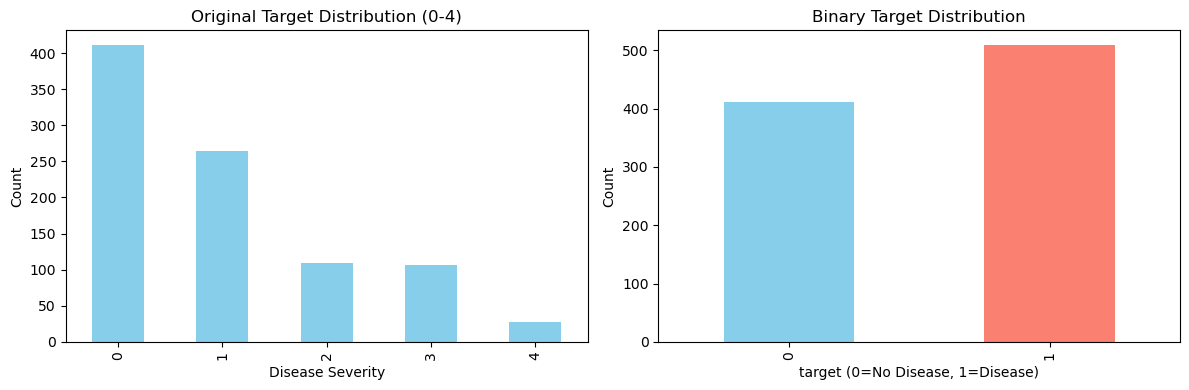

In [8]:
# Check target variable distribution
target_col = 'num'
print("Target variable distribution:")
print("="*50)
print(df[target_col].value_counts().sort_index())
print(f"\nUnique values: {sorted(df[target_col].unique())}")

# Convert to binary classification: 0 = no disease, 1 = disease present (1-4)
df['target'] = (df[target_col] > 0).astype(int)
print(f"\nBinary target distribution:")
print(df['target'].value_counts().sort_index())
print(f"\nClass balance: {df['target'].value_counts(normalize=True)}")

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Original multi-class target
df[target_col].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Original Target Distribution (0-4)')
axes[0].set_xlabel('Disease Severity')
axes[0].set_ylabel('Count')

# Binary target
df['target'].value_counts().sort_index().plot(kind='bar', ax=axes[1], color=['skyblue', 'salmon'])
axes[1].set_title('Binary Target Distribution')
axes[1].set_xlabel('target (0=No Disease, 1=Disease)')
axes[1].set_ylabel('Count')
axes[1].set_xticks([0, 1])

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'figures' / 'target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Data Preprocessing
**Task:** Handle missing values and encode categorical variables

In [9]:
# Identify numeric and categorical features
# Exclude id, dataset, and target columns
exclude_cols = ['id', 'dataset', 'num', 'target']
feature_cols = [col for col in df.columns if col not in exclude_cols]

# Separate numeric and categorical features
numeric_features = df[feature_cols].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df[feature_cols].select_dtypes(include=['object']).columns.tolist()

print(f"Numeric features: {numeric_features}")
print(f"\nCategorical features: {categorical_features}")

# For categorical features, we'll use LabelEncoder manually
# Note: Numeric features will be imputed after splitting to avoid leakage
df_processed = df.copy()
for col in categorical_features:
    le = LabelEncoder()
    # Fill categorical missing values with mode
    df_processed[col] = df_processed[col].fillna(df_processed[col].mode()[0] if not df_processed[col].mode().empty else 'Unknown')
    df_processed[col] = le.fit_transform(df_processed[col].astype(str))

print("\nCategorical encoding complete! Numeric imputation will be done after split.")

Numeric features: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']

Categorical features: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

Categorical encoding complete! Numeric imputation will be done after split.


## 6. Train-Test Split and Scaling
**Task:** Split the data into training and testing sets, then impute and scale numeric features

In [10]:
# Prepare features and target
X = df_processed[feature_cols]
y = df_processed['target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"\nTraining set class distribution:")
print(y_train.value_counts(normalize=True))
print(f"\nTest set class distribution:")
print(y_test.value_counts(normalize=True))

# 1. Impute missing values in numeric features
imputer = SimpleImputer(strategy='median')
X_train_imputed = X_train.copy()
X_test_imputed = X_test.copy()

if numeric_features:
    X_train_imputed[numeric_features] = imputer.fit_transform(X_train[numeric_features])
    X_test_imputed[numeric_features] = imputer.transform(X_test[numeric_features])

# 2. Scale features
scaler = StandardScaler()
X_train_scaled = X_train_imputed.copy()
X_test_scaled = X_test_imputed.copy()

if numeric_features:
    X_train_scaled[numeric_features] = scaler.fit_transform(X_train_imputed[numeric_features])
    X_test_scaled[numeric_features] = scaler.transform(X_test_imputed[numeric_features])

print("\nData split, imputation, and scaling complete!")

Training set size: (736, 13)
Test set size: (184, 13)

Training set class distribution:
target
1    0.552989
0    0.447011
Name: proportion, dtype: float64

Test set class distribution:
target
1    0.554348
0    0.445652
Name: proportion, dtype: float64

Data split, imputation, and scaling complete!


## 7. Model Training - Logistic Regression
**Task:** Train and evaluate a Logistic Regression model

In [11]:
# Train Logistic Regression with balanced class weights
lr_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("="*60)
print("LOGISTIC REGRESSION RESULTS")
print("="*60)
print(f"\nAccuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lr):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

LOGISTIC REGRESSION RESULTS

Accuracy: 0.8152
Precision: 0.8333
Recall: 0.8333
F1-Score: 0.8333
ROC-AUC: 0.8945

Confusion Matrix:
[[65 17]
 [17 85]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        82
           1       0.83      0.83      0.83       102

    accuracy                           0.82       184
   macro avg       0.81      0.81      0.81       184
weighted avg       0.82      0.82      0.82       184



## 8. Model Training - Random Forest
**Task:** Train and evaluate a Random Forest model

In [12]:
# Train Random Forest with balanced class weights
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("="*60)
print("RANDOM FOREST RESULTS")
print("="*60)
print(f"\nAccuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

RANDOM FOREST RESULTS

Accuracy: 0.8370
Precision: 0.8333
Recall: 0.8824
F1-Score: 0.8571
ROC-AUC: 0.9216

Confusion Matrix:
[[64 18]
 [12 90]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.78      0.81        82
           1       0.83      0.88      0.86       102

    accuracy                           0.84       184
   macro avg       0.84      0.83      0.83       184
weighted avg       0.84      0.84      0.84       184



## 9. Model Comparison
**Task:** Compare the performance of both models

In [13]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf)
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_rf)
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_rf)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_rf)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_pred_proba_lr),
        roc_auc_score(y_test, y_pred_proba_rf)
    ]
})

print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
print(comparison_df.round(4))

# Save comparison results
comparison_df.to_csv(OUTPUT_DIR / 'model_comparison.csv', index=False)
print("\nComparison results saved to 'outputs/model_comparison.csv'")


MODEL COMPARISON
                 Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
0  Logistic Regression    0.8152     0.8333  0.8333    0.8333   0.8945
1        Random Forest    0.8370     0.8333  0.8824    0.8571   0.9216

Comparison results saved to 'outputs/model_comparison.csv'


## 10. Feature Importance (Random Forest)
**Task:** Analyze feature importance from the Random Forest model

Feature Importance (Random Forest):
     Feature  Importance
4       chol    0.154179
2         cp    0.143228
7     thalch    0.130105
0        age    0.130104
9    oldpeak    0.108376
8      exang    0.084436
3   trestbps    0.075520
1        sex    0.040748
12      thal    0.035343
6    restecg    0.034003
11        ca    0.024082
10     slope    0.023079
5        fbs    0.016797


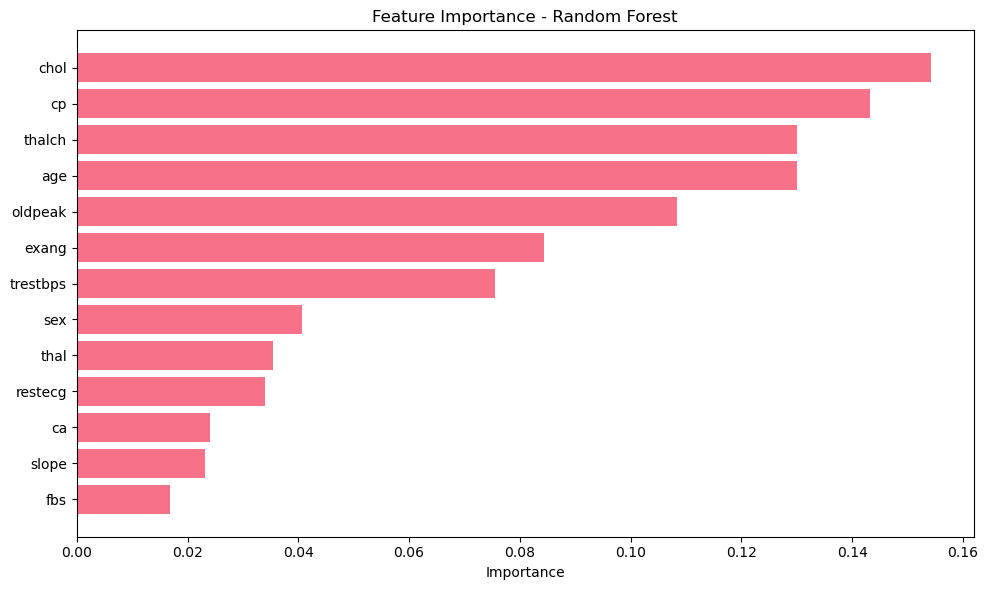

In [14]:
# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importance (Random Forest):")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'figures' / 'feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## 11. Unsupervised Learning - K-Means Clustering
**Task:** Apply K-Means clustering for feature engineering

In [15]:
from sklearn.cluster import KMeans

# Apply K-Means clustering (k=3)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
train_clusters = kmeans.fit_predict(X_train_scaled[numeric_features])
test_clusters = kmeans.predict(X_test_scaled[numeric_features])

print("K-Means Clustering Complete")
print(f"Cluster distribution: {pd.Series(train_clusters).value_counts().sort_index()}")

# Analyze clusters
X_train_analysis = X_train_scaled.copy()
X_train_analysis['cluster'] = train_clusters
X_train_analysis['target'] = y_train.values

cluster_disease_rate = X_train_analysis.groupby('cluster')['target'].mean().sort_values()
print(f"\nDisease rate by cluster:\n{cluster_disease_rate}")

# Map to risk levels
cluster_risk_mapping = {cluster_disease_rate.index[0]: 0, 
                        cluster_disease_rate.index[1]: 1, 
                        cluster_disease_rate.index[2]: 2}

# Add as feature
train_risk = np.array([cluster_risk_mapping[c] for c in train_clusters])
test_risk = np.array([cluster_risk_mapping[c] for c in test_clusters])

X_train_scaled['risk_cluster'] = train_risk
X_test_scaled['risk_cluster'] = test_risk

print(f"\nRisk cluster feature added (0=Low, 1=Medium, 2=High)")

K-Means Clustering Complete
Cluster distribution: 0    342
1     70
2    324
Name: count, dtype: int64

Disease rate by cluster:
cluster
0    0.309942
2    0.756173
1    0.800000
Name: target, dtype: float64

Risk cluster feature added (0=Low, 1=Medium, 2=High)


## 12. Cross-Validation Analysis
**Task:** Evaluate model stability using 5-fold cross-validation

In [16]:
from sklearn.model_selection import cross_validate, StratifiedKFold

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Logistic Regression CV
lr_cv = cross_validate(
    LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
    X_train_scaled, y_train, cv=cv_strategy, scoring=scoring, n_jobs=-1
)

# Random Forest CV
rf_cv = cross_validate(
    RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100),
    X_train_scaled, y_train, cv=cv_strategy, scoring=scoring, n_jobs=-1
)

print("Cross-Validation Results (Mean ± Std):")
print(f"\nLogistic Regression:")
for metric in scoring:
    scores = lr_cv[f'test_{metric}']
    print(f"  {metric}: {scores.mean():.4f} ± {scores.std():.4f}")

print(f"\nRandom Forest:")
for metric in scoring:
    scores = rf_cv[f'test_{metric}']
    print(f"  {metric}: {scores.mean():.4f} ± {scores.std():.4f}")

Cross-Validation Results (Mean ± Std):

Logistic Regression:
  accuracy: 0.7908 ± 0.0076
  precision: 0.8344 ± 0.0268
  recall: 0.7786 ± 0.0430
  f1: 0.8041 ± 0.0126
  roc_auc: 0.8709 ± 0.0123

Random Forest:
  accuracy: 0.8030 ± 0.0143
  precision: 0.8085 ± 0.0306
  recall: 0.8475 ± 0.0367
  f1: 0.8263 ± 0.0100
  roc_auc: 0.8659 ± 0.0216


## 13. Hyperparameter Tuning with GridSearchCV
**Task:** Optimize Random Forest hyperparameters

In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': [100, 200]
}

grid_search = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42),
    param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV ROC-AUC: {grid_search.best_score_:.4f}")

# Evaluate on test set
rf_tuned = grid_search.best_estimator_
y_pred_tuned = rf_tuned.predict(X_test_scaled)
y_pred_proba_tuned = rf_tuned.predict_proba(X_test_scaled)[:, 1]

print(f"\nTuned Model Test Performance:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_tuned):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_pred_proba_tuned):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_tuned):.4f}")

print(f"\nBaseline vs Tuned:")
print(f"  Baseline ROC-AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")
print(f"  Tuned ROC-AUC: {roc_auc_score(y_test, y_pred_proba_tuned):.4f}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best CV ROC-AUC: 0.8793

Tuned Model Test Performance:
  Accuracy: 0.8261
  ROC-AUC: 0.9167
  Recall: 0.8627

Baseline vs Tuned:
  Baseline ROC-AUC: 0.9216
  Tuned ROC-AUC: 0.9167
